# DNN Performance Drop Prediction

**Purpose** Train a DNN-based meta-model to predict a primary model accuracy drop (on various shifted datasets) and beat the baseline.

**Primary Task** RandomForestClassifier to predict low/high sales of video games records. Accuracy on clean validation set 0.798.

**Data for the Performance Drop Regressor**
- training: 500 datasets (X1), their accuracy drop (y), their meta-features (X2)
- validation: take a random split of the previous, if needed.
- test data:
   1. test: 500 datasets (X1) with same shifts as in the training, but different severity (and their X2 and y).
   2. test_unseen: 900 datasets (X1) with other types of shifts, not seen at training time (and their X2 and y).
   3. test_natural: 10 datasets (X1) coming from different domains, but same primary task (and their X2 and y).
   
Each dataset has 475 rows and 9 features (preprocessed already).

Each meta-feature vector contains 114 features (will be preprocessed in this notebook to 110 final features).

**Baseline**

Baseline-Meta-Features: RandomForestRegressor trained on meta features only (prediction_percentiles, PAD, RCA, confidence drop, BBSDs KS and BBSDh X2 statistics, KS statistics on individual preprocessed features.

### Imports

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
tf.experimental.output_all_intermediates(True)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from matplotlib import pyplot as plt

Here import of the class I'm using to train DNNs in keras, where you can choose among 3 types of encoders 'mlp', 'lstm' or 'odt' (oblivious decision tree). 

Have a look at `_make_model()`.

In [3]:
import tensorflow.compat.v1 as tf

tf.disable_v2_behavior()

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, Layer, Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model as KerasModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from tensorflow.random import set_seed as set_random_seed
from node.networks.layer import ObliviousDecisionTree
import numpy as np
import os
import math
import copy


class RandomSamplePermutation(Layer):
    def __init__(self, n_samples=500, **kwargs):
        super(RandomSamplePermutation, self).__init__(**kwargs)
        self.n_samples = n_samples

    def call(self, datasets, training=None):
        if not training:
            return datasets

        permuted_indices = np.random.permutation(self.n_samples)

        return datasets[:, permuted_indices, :]

    def get_config(self):
        return {"n_samples": self.n_samples,
                "name": 'rnd_permutation'}


class VectorizedODT(Layer):
    def __init__(self, n_trees=1,
                 depth=1,
                 units=100,
                 threshold_init_beta=1.,
                 name='vec_odt',
                 **kwargs):
        super(VectorizedODT, self).__init__(name=name, **kwargs)
        self.odt_layer = ObliviousDecisionTree(n_trees=n_trees,
                                               depth=depth,
                                               units=units,
                                               threshold_init_beta=threshold_init_beta)

    def call(self, input_numeric, training=None):
        dataset_encoder = tf.vectorized_map(self.odt_layer, input_numeric)

        return dataset_encoder

    def get_config(self):
        return {"n_trees": self.odt_layer.n_trees,
                "depth": self.odt_layer.depth,
                "units": self.odt_layer.units,
                "threshold_init_beta": self.odt_layer.threshold_init_beta,
                "name": self.name}


class MultiDomainPerformancePredictorDNN():
    def __init__(self, n_samples, n_features, encoded_ds_size=10, hidden_size=5,
                 encoder_type='mlp', n_trees=3, depth=3, threshold_init_beta=1., lr=0.01):
        self.n_features = n_features
        self.n_samples = n_samples

        self.n_samples_per_dataset = n_samples
        self.n_features = n_features
        self.encoded_ds_size = encoded_ds_size
        self.hidden_size = hidden_size

        self.n_trees = n_trees
        self.depth = depth
        self.threshold_init_beta = threshold_init_beta

        self.history = None
        self.lr = lr

        valid_encoder_types = ['mlp', 'lstm', 'odt']
        if encoder_type not in valid_encoder_types:
            raise ValueError('Encoder type must be one of: %s.' % str(valid_encoder_types))
        self.encoder_type = encoder_type

        self.model = self._make_model()
        self._compile(self.lr)

    def _make_encoder(self, input_numeric):

        input_shape = (self.n_samples_per_dataset, self.n_features)

        if self.encoder_type == 'lstm':
            dataset_encoder = Bidirectional(
                LSTM(units=self.encoded_ds_size, return_sequences=False,
                     input_shape=input_shape), name='encoded_dataset')(input_numeric)

        elif self.encoder_type == 'mlp':

            dataset_encoder = Dense(units=self.encoded_ds_size, kernel_initializer='normal',
                                    activation='relu', name='ds_dense')(input_numeric)
            dataset_encoder = GlobalAveragePooling1D()(dataset_encoder)
            dataset_encoder = Dense(self.hidden_size, kernel_initializer='normal',
                                    activation='relu', name='ds_avg_dense')(dataset_encoder)

        elif self.encoder_type == 'odt':

            dataset_encoder = VectorizedODT(n_trees=self.n_trees, depth=self.depth, units=self.encoded_ds_size,
                                            threshold_init_beta=self.threshold_init_beta)(input_numeric)
            dataset_encoder = GlobalAveragePooling1D()(dataset_encoder)

        else:
            raise NotImplementedError('Only lstm, mlp and odt are supported.')

        return dataset_encoder

    def _make_branches(self, encoded_data):

        # single branch for drop prediction
        encoded_data = Dropout(0.2, name='perf_drop_dropout')(encoded_data)
        performance_drop = Dense(1, kernel_initializer='normal', name='perf_drop')(encoded_data)
        output_model = performance_drop

        return output_model

    def _compile(self, lr=0.01):
        self.model.compile(
            loss='mean_absolute_error',
            optimizer=Adam(lr),
            metrics=['mean_absolute_error']
        )
        
    def _make_model(self) -> KerasModel:
        """
        This method is used to generate a Keras Model containing the DNN performance predictor
        :return: a compiled Keras Model object
        """

        input_numeric = Input(shape=(self.n_samples_per_dataset, self.n_features), name='dataset')

        input_numeric_permuted = RandomSamplePermutation(n_samples=self.n_samples_per_dataset, name='permuted_dataset')(
            input_numeric)

        encoded_data = self._make_encoder(input_numeric_permuted)

        output_model = self._make_branches(encoded_data)

        model = KerasModel(inputs=input_numeric, outputs=output_model)

        return model

    def _step_decay(self, epoch):
        initial_lrate = self.lr
        drop = 0.5
        epochs_drop = 10.0
        lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
        return lrate

    def _fixed_lr(self, epoch):
        return self.lr

    def fit(self, list_X, list_y_drop, random_state=1234, epochs=100, batch_size=256,
            validation_split=0.2, verbose=0, early_stop_patience=10, lr=None,
            reduce_lr_plateau=True, validation_data=None):

        np.random.seed(random_state)
        set_random_seed(random_state)

        if os.path.exists('./mdc_net.h5'):
            os.remove('./mdc_net.h5')

        if lr is not None:
            self.lr = lr
            self._compile(self.lr)

        if validation_split != 0 or (validation_data is not None):
            callbacks = [
                ModelCheckpoint(filepath='./mdc_net.h5', monitor='val_loss', verbose=verbose,
                                save_best_only=True, mode='min'),
                EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=early_stop_patience)]

            if reduce_lr_plateau:
                callbacks += [
                    ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=self.lr * 0.01,
                                      verbose=verbose)]
            else:
                callbacks += [LearningRateScheduler(self._fixed_lr)]
        else:
            callbacks = [LearningRateScheduler(self._fixed_lr)]

        input_X = list_X

        input_y = list_y_drop

        self.history = self.model.fit(
            input_X,
            input_y,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=verbose
        )

        if validation_split != 0 or (validation_data is not None):
            self.model = load_model('./mdc_net.h5', custom_objects={'RandomSamplePermutation': RandomSamplePermutation,
                                                                    'VectorizedODT': VectorizedODT})

    def predict(self, list_X):

        drop_pred = self.model.predict(list_X)

        return np.clip(drop_pred, -1., 1.)

### Loading Data and some simple preprocessing

In [4]:
fld = 'data'

In [5]:
with open(os.path.join(fld, 'data.pkl'), 'rb') as f:
    out = pickle.load(f)

In [6]:
train, test, test_unseen, test_natural, ref_task, result_df = out

In [7]:
X_train_1 = train.datasets
y_train = train.drops
train_meta_features_orig = train.meta_features
train_drift_types = train.drift_types

In [8]:
X_test_1 = test.datasets
y_test = test.drops
test_meta_features_orig = test.meta_features
test_drift_types = test.drift_types

In [9]:
X_test_unseen_1 = test_unseen.datasets
y_test_unseen = test_unseen.drops
test_unseen_meta_features_orig = test_unseen.meta_features

In [10]:
X_test_natural_1 = test_natural.datasets
y_test_natural = test_natural.drops
test_natural_meta_features_orig = test_natural.meta_features

In [11]:
test_natural_meta_features_orig.shape

(10, 114)

In [12]:
imp = Pipeline([('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('scaler', MinMaxScaler())])

X_train_2 = imp.fit_transform(train_meta_features_orig)
X_test_2 = imp.transform(test_meta_features_orig)
X_test_unseen_2 = imp.transform(test_unseen_meta_features_orig)
X_test_natural_2 = imp.transform(test_natural_meta_features_orig)

In [13]:
X_train_1.shape

(500, 475, 9)

In [14]:
X_train_2.shape

(500, 110)

In [15]:
X_test_1.shape

(500, 475, 9)

In [16]:
X_test_unseen_1.shape

(900, 475, 9)

In [17]:
X_test_natural_1.shape

(10, 475, 9)

Here is the reference task

In [18]:
model = ref_task.model

In [19]:
# source validation dataset
X_src = ref_task.X_orig
y_src = ref_task.y

# reference accuracy
model.score(ref_task.preprocess.transform(X_src), y_src)

0.7978947368421052

You can extract primary predictions for all datasets, and possibly use them as additional features.

In [20]:
X_train_pred = np.array([model.predict_proba(X) for X in X_train_1])
X_train_pred.shape

(500, 475, 2)

In [21]:
X_test_pred = np.array([model.predict_proba(X) for X in X_test_1])
X_test_pred.shape

(500, 475, 2)

In [22]:
X_test_unseen_pred = np.array([model.predict_proba(X) for X in X_test_unseen_1])
X_test_unseen_pred.shape

(900, 475, 2)

In [23]:
X_test_natural_pred = np.array([model.predict_proba(X) for X in X_test_natural_1])
X_test_natural_pred.shape

(10, 475, 2)

### Baseline: Random Forest Regresson on Meta-Features

In [24]:
print("Train Drift Features Baseline Performance Drop Predictor...")

regr = RandomForestRegressor().fit(X_train_2, y_train)

print("Evaluate Drift Features Baseline and save results...")

y_train_drops_pred = regr.predict(X_train_2)

y_test_drops_pred = regr.predict(X_test_2)

y_test_unseen_drops_pred = regr.predict(X_test_unseen_2)

y_test_natural_drops_pred = regr.predict(X_test_natural_2)

Train Drift Features Baseline Performance Drop Predictor...
Evaluate Drift Features Baseline and save results...


In [25]:
mean_absolute_error(y_train, y_train_drops_pred)

0.014821305263157891

In [26]:
mean_absolute_error(y_test, y_test_drops_pred)

0.04080067368421052

In [27]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.06021118128654971

In [28]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05922105263157891

## Training DNNs

If using the MultiDomainPerformancePredictorDNN, do not change the default multi_task, drop_branch, n_domains: with these defaults the DNN is a simple DNN regressors.

Instead play with the network (mlp, lstm, odt), the sizes of the various layer, regularizations, augmentations.

Make sure on multiple runs of training, that results are stable.

Can you make the **training error** go lower than 4% as a start ?

### Using datasets only, with no meta-features

In [30]:
print("Define DNN Performance Drop Predictor...")

drop_predictor = MultiDomainPerformancePredictorDNN(n_samples=X_train_1.shape[1],
                                                    n_features=X_train_1.shape[2],
                                                    encoded_ds_size=10, 
                                                    hidden_size=5,  
                                                    encoder_type='lstm')


Define DNN Performance Drop Predictor...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2021-10-20 11:57:39.272319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [31]:
drop_predictor.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dataset (InputLayer)         [(None, 475, 9)]          0         
_________________________________________________________________
permuted_dataset (RandomSamp (None, 475, 9)            0         
_________________________________________________________________
encoded_dataset (Bidirection (None, 20)                1600      
_________________________________________________________________
perf_drop_dropout (Dropout)  (None, 20)                0         
_________________________________________________________________
perf_drop (Dense)            (None, 1)                 21        
Total params: 1,621
Trainable params: 1,621
Non-trainable params: 0
_________________________________________________________________


In [32]:
print("Train DNN Performance Drop Predictor...")

verbose = True

drop_predictor.fit(X_train_1, y_train, None, epochs=300, batch_size=400,
            validation_split=0.2, verbose=verbose, early_stop_patience=100, lr=0.001)

Train DNN Performance Drop Predictor...
Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - ETA: 0s - loss: 0.1550 - mean_absolute_error: 0.1550
Epoch 00001: val_loss improved from inf to 0.12607, saving model to ./mdc_net.h5


/Users/smaggio/workspace/dnn_performance_drop_prediction_under_drift/env_dnn_performance_drop_prediction/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


400/400 [==============================] - 1s 2ms/sample - loss: 0.1550 - mean_absolute_error: 0.1550 - val_loss: 0.1261 - val_mean_absolute_error: 0.1261 - lr: 0.0010
Epoch 2/300
400/400 [==============================] - ETA: 0s - loss: 0.1458 - mean_absolute_error: 0.1458
Epoch 00002: val_loss improved from 0.12607 to 0.12165, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 662us/sample - loss: 0.1458 - mean_absolute_error: 0.1458 - val_loss: 0.1217 - val_mean_absolute_error: 0.1217 - lr: 0.0010
Epoch 3/300
400/400 [==============================] - ETA: 0s - loss: 0.1412 - mean_absolute_error: 0.1412
Epoch 00003: val_loss improved from 0.12165 to 0.11715, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 621us/sample - loss: 0.1412 - mean_absolute_error: 0.1412 - val_loss: 0.1171 - val_mean_absolute_error: 0.1171 - lr: 0.0010
Epoch 4/300
400/400 [==============================] - ETA: 0s - loss: 0.1404 - mean_absolute_error: 0.140

400/400 [==============================] - ETA: 0s - loss: 0.0805 - mean_absolute_error: 0.0805
Epoch 00024: val_loss improved from 0.06683 to 0.06565, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 600us/sample - loss: 0.0805 - mean_absolute_error: 0.0805 - val_loss: 0.0656 - val_mean_absolute_error: 0.0656 - lr: 0.0010
Epoch 25/300
400/400 [==============================] - ETA: 0s - loss: 0.0813 - mean_absolute_error: 0.0813
Epoch 00025: val_loss improved from 0.06565 to 0.06462, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 670us/sample - loss: 0.0813 - mean_absolute_error: 0.0813 - val_loss: 0.0646 - val_mean_absolute_error: 0.0646 - lr: 0.0010
Epoch 26/300
400/400 [==============================] - ETA: 0s - loss: 0.0789 - mean_absolute_error: 0.0789
Epoch 00026: val_loss improved from 0.06462 to 0.06354, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 681us/sample - loss: 0.0789 - mean_absolute_e

Epoch 47/300
400/400 [==============================] - ETA: 0s - loss: 0.0632 - mean_absolute_error: 0.0632
Epoch 00047: val_loss improved from 0.04842 to 0.04819, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 733us/sample - loss: 0.0632 - mean_absolute_error: 0.0632 - val_loss: 0.0482 - val_mean_absolute_error: 0.0482 - lr: 0.0010
Epoch 48/300
400/400 [==============================] - ETA: 0s - loss: 0.0543 - mean_absolute_error: 0.0543
Epoch 00048: val_loss improved from 0.04819 to 0.04802, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 683us/sample - loss: 0.0543 - mean_absolute_error: 0.0543 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480 - lr: 0.0010
Epoch 49/300
400/400 [==============================] - ETA: 0s - loss: 0.0577 - mean_absolute_error: 0.0577
Epoch 00049: val_loss improved from 0.04802 to 0.04719, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 668us/sample - loss: 0.0577 - me

Epoch 70/300
400/400 [==============================] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511
Epoch 00070: val_loss improved from 0.04352 to 0.04341, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 713us/sample - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - lr: 0.0010
Epoch 71/300
400/400 [==============================] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511
Epoch 00071: val_loss improved from 0.04341 to 0.04335, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 689us/sample - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0434 - val_mean_absolute_error: 0.0434 - lr: 0.0010
Epoch 72/300
400/400 [==============================] - ETA: 0s - loss: 0.0519 - mean_absolute_error: 0.0519
Epoch 00072: val_loss improved from 0.04335 to 0.04330, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 696us/sample - loss: 0.0519 - me

Epoch 93/300
400/400 [==============================] - ETA: 0s - loss: 0.0408 - mean_absolute_error: 0.0408
Epoch 00093: val_loss improved from 0.04053 to 0.04052, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 697us/sample - loss: 0.0408 - mean_absolute_error: 0.0408 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405 - lr: 0.0010
Epoch 94/300
400/400 [==============================] - ETA: 0s - loss: 0.0442 - mean_absolute_error: 0.0442
Epoch 00094: val_loss improved from 0.04052 to 0.04050, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 632us/sample - loss: 0.0442 - mean_absolute_error: 0.0442 - val_loss: 0.0405 - val_mean_absolute_error: 0.0405 - lr: 0.0010
Epoch 95/300
400/400 [==============================] - ETA: 0s - loss: 0.0417 - mean_absolute_error: 0.0417
Epoch 00095: val_loss improved from 0.04050 to 0.04048, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 671us/sample - loss: 0.0417 - me

400/400 [==============================] - ETA: 0s - loss: 0.0398 - mean_absolute_error: 0.0398
Epoch 00115: val_loss improved from 0.03973 to 0.03963, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 681us/sample - loss: 0.0398 - mean_absolute_error: 0.0398 - val_loss: 0.0396 - val_mean_absolute_error: 0.0396 - lr: 9.0000e-04
Epoch 116/300
400/400 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.0380
Epoch 00116: val_loss improved from 0.03963 to 0.03954, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 676us/sample - loss: 0.0380 - mean_absolute_error: 0.0380 - val_loss: 0.0395 - val_mean_absolute_error: 0.0395 - lr: 9.0000e-04
Epoch 117/300
400/400 [==============================] - ETA: 0s - loss: 0.0385 - mean_absolute_error: 0.0385
Epoch 00117: val_loss improved from 0.03954 to 0.03943, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 663us/sample - loss: 0.0385 - mean_

400/400 [==============================] - ETA: 0s - loss: 0.0352 - mean_absolute_error: 0.0352
Epoch 00137: val_loss improved from 0.03831 to 0.03827, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 621us/sample - loss: 0.0352 - mean_absolute_error: 0.0352 - val_loss: 0.0383 - val_mean_absolute_error: 0.0383 - lr: 9.0000e-04
Epoch 138/300
400/400 [==============================] - ETA: 0s - loss: 0.0344 - mean_absolute_error: 0.0344
Epoch 00138: val_loss improved from 0.03827 to 0.03824, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 1ms/sample - loss: 0.0344 - mean_absolute_error: 0.0344 - val_loss: 0.0382 - val_mean_absolute_error: 0.0382 - lr: 9.0000e-04
Epoch 139/300
400/400 [==============================] - ETA: 0s - loss: 0.0349 - mean_absolute_error: 0.0349
Epoch 00139: val_loss improved from 0.03824 to 0.03820, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 911us/sample - loss: 0.0349 - mean_ab

400/400 [==============================] - ETA: 0s - loss: 0.0330 - mean_absolute_error: 0.0330
Epoch 00159: val_loss improved from 0.03777 to 0.03774, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 687us/sample - loss: 0.0330 - mean_absolute_error: 0.0330 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - lr: 9.0000e-04
Epoch 160/300
400/400 [==============================] - ETA: 0s - loss: 0.0334 - mean_absolute_error: 0.0334
Epoch 00160: val_loss improved from 0.03774 to 0.03772, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 681us/sample - loss: 0.0334 - mean_absolute_error: 0.0334 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - lr: 9.0000e-04
Epoch 161/300
400/400 [==============================] - ETA: 0s - loss: 0.0325 - mean_absolute_error: 0.0325
Epoch 00161: val_loss improved from 0.03772 to 0.03771, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 654us/sample - loss: 0.0325 - mean_

Epoch 182/300
400/400 [==============================] - ETA: 0s - loss: 0.0317 - mean_absolute_error: 0.0317
Epoch 00182: val_loss did not improve from 0.03766
400/400 [==============================] - 0s 603us/sample - loss: 0.0317 - mean_absolute_error: 0.0317 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - lr: 5.9049e-04
Epoch 183/300
400/400 [==============================] - ETA: 0s - loss: 0.0312 - mean_absolute_error: 0.0312
Epoch 00183: val_loss improved from 0.03766 to 0.03765, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 759us/sample - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0377 - val_mean_absolute_error: 0.0377 - lr: 5.9049e-04
Epoch 184/300
400/400 [==============================] - ETA: 0s - loss: 0.0300 - mean_absolute_error: 0.0300
Epoch 00184: val_loss improved from 0.03765 to 0.03765, saving model to ./mdc_net.h5

Epoch 00184: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
400/400 [===========

400/400 [==============================] - ETA: 0s - loss: 0.0301 - mean_absolute_error: 0.0301
Epoch 00204: val_loss improved from 0.03752 to 0.03751, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 647us/sample - loss: 0.0301 - mean_absolute_error: 0.0301 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - lr: 3.8742e-04
Epoch 205/300
400/400 [==============================] - ETA: 0s - loss: 0.0316 - mean_absolute_error: 0.0316
Epoch 00205: val_loss improved from 0.03751 to 0.03751, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 667us/sample - loss: 0.0316 - mean_absolute_error: 0.0316 - val_loss: 0.0375 - val_mean_absolute_error: 0.0375 - lr: 3.8742e-04
Epoch 206/300
400/400 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311
Epoch 00206: val_loss improved from 0.03751 to 0.03750, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 664us/sample - loss: 0.0311 - mean_

Epoch 226/300
400/400 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314
Epoch 00226: val_loss improved from 0.03741 to 0.03740, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 641us/sample - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 2.8243e-04
Epoch 227/300
400/400 [==============================] - ETA: 0s - loss: 0.0314 - mean_absolute_error: 0.0314
Epoch 00227: val_loss improved from 0.03740 to 0.03738, saving model to ./mdc_net.h5

Epoch 00227: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
400/400 [==============================] - 0s 645us/sample - loss: 0.0314 - mean_absolute_error: 0.0314 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 2.8243e-04
Epoch 228/300
400/400 [==============================] - ETA: 0s - loss: 0.0313 - mean_absolute_error: 0.0313
Epoch 00228: val_loss improved from 0.03738 to 0.03737, saving model t

400/400 [==============================] - ETA: 0s - loss: 0.0311 - mean_absolute_error: 0.0311
Epoch 00248: val_loss did not improve from 0.03732
400/400 [==============================] - 0s 580us/sample - loss: 0.0311 - mean_absolute_error: 0.0311 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 1.8530e-04
Epoch 249/300
400/400 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298
Epoch 00249: val_loss did not improve from 0.03732

Epoch 00249: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
400/400 [==============================] - 0s 669us/sample - loss: 0.0298 - mean_absolute_error: 0.0298 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 1.8530e-04
Epoch 250/300
400/400 [==============================] - ETA: 0s - loss: 0.0298 - mean_absolute_error: 0.0298
Epoch 00250: val_loss did not improve from 0.03732
400/400 [==============================] - 0s 751us/sample - loss: 0.0298 - mean_absolute_error: 0.02

400/400 [==============================] - ETA: 0s - loss: 0.0303 - mean_absolute_error: 0.0303
Epoch 00271: val_loss did not improve from 0.03732
400/400 [==============================] - 0s 628us/sample - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 1.0942e-04
Epoch 272/300
400/400 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296
Epoch 00272: val_loss did not improve from 0.03732
400/400 [==============================] - 0s 613us/sample - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 1.0942e-04
Epoch 273/300
400/400 [==============================] - ETA: 0s - loss: 0.0296 - mean_absolute_error: 0.0296
Epoch 00273: val_loss did not improve from 0.03732
400/400 [==============================] - 0s 595us/sample - loss: 0.0296 - mean_absolute_error: 0.0296 - val_loss: 0.0374 - val_mean_absolute_error: 0.0374 - lr: 1.0942e-04
Epoch 274

Epoch 295/300
400/400 [==============================] - ETA: 0s - loss: 0.0306 - mean_absolute_error: 0.0306
Epoch 00295: val_loss improved from 0.03731 to 0.03731, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 666us/sample - loss: 0.0306 - mean_absolute_error: 0.0306 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - lr: 6.4611e-05
Epoch 296/300
400/400 [==============================] - ETA: 0s - loss: 0.0299 - mean_absolute_error: 0.0299
Epoch 00296: val_loss improved from 0.03731 to 0.03731, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 650us/sample - loss: 0.0299 - mean_absolute_error: 0.0299 - val_loss: 0.0373 - val_mean_absolute_error: 0.0373 - lr: 6.4611e-05
Epoch 297/300
400/400 [==============================] - ETA: 0s - loss: 0.0307 - mean_absolute_error: 0.0307
Epoch 00297: val_loss improved from 0.03731 to 0.03730, saving model to ./mdc_net.h5
400/400 [==============================] - 0s 667us/sample - loss: 

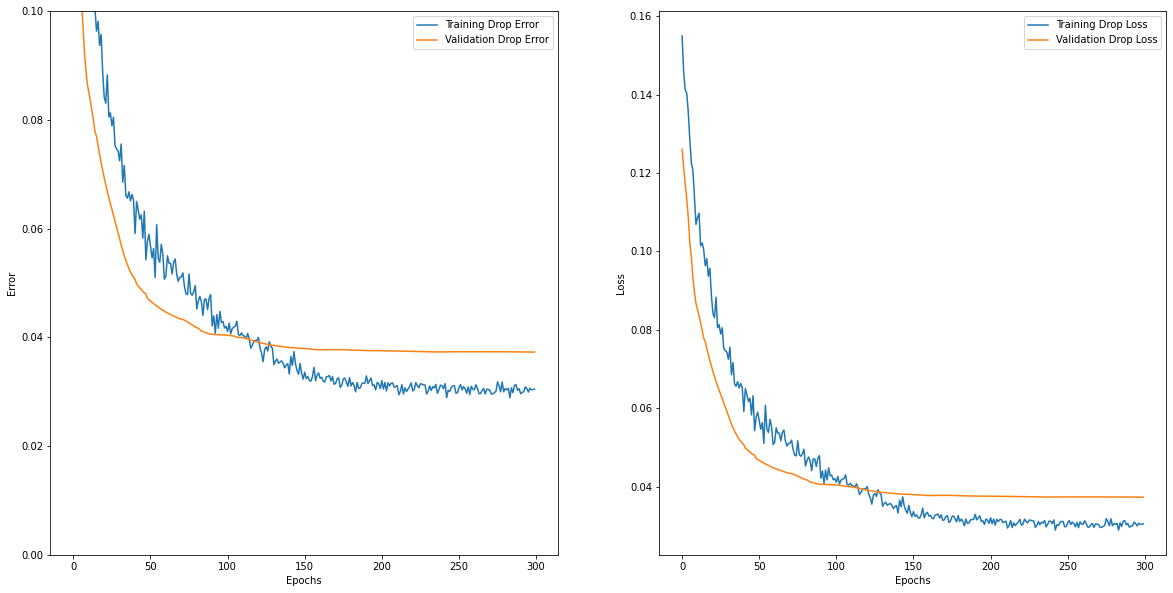

In [33]:
history = drop_predictor.history

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Error")

ax1.plot(history.history['mean_absolute_error'], label="Training Drop Error")
if 'val_mean_absolute_error' in history.history:
    ax1.plot(history.history['val_mean_absolute_error'], label="Validation Drop Error")
ax1.legend()
ax1.set_ylim(0., 0.1)

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

ax2.plot(history.history['loss'], label="Training Drop Loss")
if 'val_loss' in history.history:
    ax2.plot(history.history['val_loss'], label="Validation Drop Loss")
ax2.legend()

In [34]:
print("Evaluate DNN and save results...")

y_train_drops_pred = drop_predictor.predict(X_train_1)

y_test_drops_pred = drop_predictor.predict(X_test_1)

y_test_unseen_drops_pred = drop_predictor.predict(X_test_unseen_1)

y_test_natural_drops_pred = drop_predictor.predict(X_test_natural_1)

Evaluate DNN and save results...


In [35]:
mean_absolute_error(y_train, y_train_drops_pred)

0.030197017716236018

In [36]:
mean_absolute_error(y_test, y_test_drops_pred)

0.02282016581632197

In [37]:
mean_absolute_error(y_test_unseen, y_test_unseen_drops_pred)

0.05237423460071807

In [38]:
mean_absolute_error(y_test_natural, y_test_natural_drops_pred)

0.05812009576355156